<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Introduction

This notebook builds a trading strategy around simple moving average crossovers.

# Libraries

In [1]:
import pandas as pd
import pyfolio as pf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


# Setup

In [2]:
%cd ..

/tmp/trading


In [3]:
data_dir = Path("./data")

# Data

Read the data:

In [4]:
train = pd.read_parquet(data_dir / "train.parquet")
test = pd.read_parquet(data_dir / "test.parquet")

In [5]:
test_start_date = min(test.index).to_datetime64()

Consolidate the data to compute the SMAs:

In [6]:
df = pd \
    .concat([train, test]) \
    .asfreq("D") \
    .sort_index(ascending=True)

# Modelling

Compute the moving averages:

In [7]:
# picked arbitrarily
period1 = 10
period2 = 20

In [8]:
df[f"SMA-{period1}"] = df["Close"].rolling(period1).mean()
df[f"SMA-{period2}"] = df["Close"].rolling(period2).mean()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


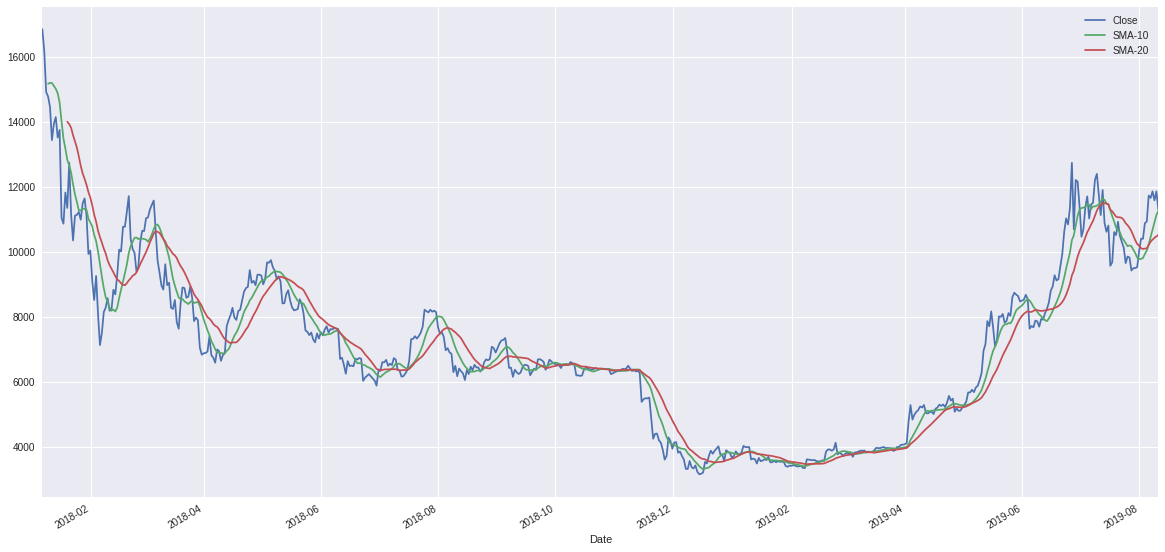

In [9]:
df[["Close", f"SMA-{period1}", f"SMA-{period2}"]] \
    .query("Date >= @test_start_date") \
    .plot(figsize=(20, 10)) 

We will buy when the `period1` SMA is greater than the `period2` SMA and short otherwise:

In [10]:
df["cross"] = df[f"SMA-{period1}"] - df[f"SMA-{period2}"]
df["signal"] = np.where(df["cross"] > 0, 1, -1)


# check the results
df.sample(n=10)

,Open,Close,High,Low,Trades,Volume,SMA-10,SMA-20,cross,signal
Date,,,,,,,,,,
2019-04-11 21:00:00+00:00,5052.0,5052.5,5053.0,5051.5,229,858189,5099.70,4554.400,545.300,1
2018-08-07 21:00:00+00:00,6876.5,6875.0,6882.0,6875.0,622,3048670,7428.80,7632.675,-203.875,-1
2018-03-10 21:00:00+00:00,8860.5,8850.0,8860.5,8848.5,268,1484936,10410.55,10408.575,1.975,1
2018-02-10 21:00:00+00:00,8171.0,8200.5,8205.5,8165.0,383,997061,8289.65,9602.775,-1313.125,-1
2019-04-29 21:00:00+00:00,5123.5,5123.0,5123.5,5122.0,239,1214884,5294.80,5225.225,69.575,1
2019-06-23 21:00:00+00:00,11059.5,11041.5,11060.0,11040.0,704,3952815,9498.50,8688.650,809.850,1
2018-08-31 21:00:00+00:00,7048.0,7048.0,7048.5,7048.0,123,1093325,6753.55,6555.825,197.725,1
2018-06-27 21:00:00+00:00,6122.0,6121.5,6121.5,6121.0,89,144324,6381.50,6575.450,-193.950,-1
2018-07-09 21:00:00+00:00,6696.5,6695.0,6699.5,6695.0,749,3384460,6565.25,6399.050,166.200,1


# Evaluation

The signal's are generated at the end of time $t$ (closing price) so it can be only acted upon at time $t+1$:

In [11]:
df["position"] = df["signal"].shift(1)

Compute the day's return:

In [12]:
df["Prev_Close"] = df["Close"].shift(1)
df["log_returns"] = np.log(df["Close"]/df["Prev_Close"])

Compute the strategy's return:

In [13]:
df["strategy_returns"] = df["position"] * df["log_returns"]

Evaluate the stategy's return on the test set:

In [14]:
returns = df[["Close", "signal", "position", "log_returns", "strategy_returns"]] \
    .query("Date >= @test_start_date")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


In [15]:
print(max(returns.index))
print(max(df.index))

2019-08-10 21:00:00+00:00
2019-08-10 21:00:00+00:00


In [16]:
np.exp(returns[["log_returns", "strategy_returns"]].sum()) - 1

log_returns        -0.317834
strategy_returns    1.233390
dtype: float64

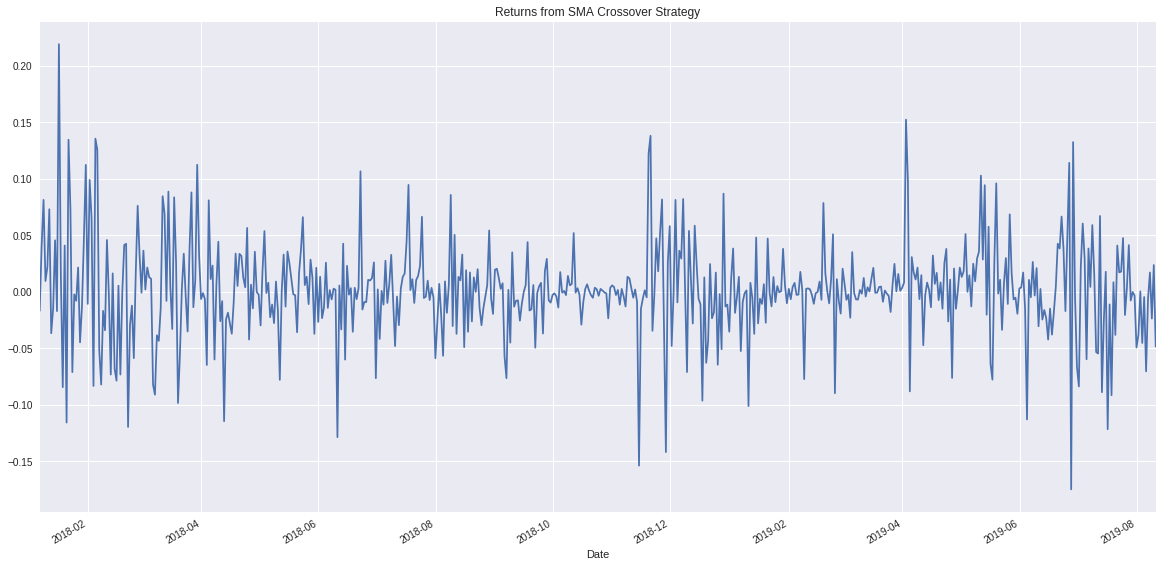

In [17]:
returns["strategy_returns"].plot(figsize=(20, 10), title="Returns from SMA Crossover Strategy")

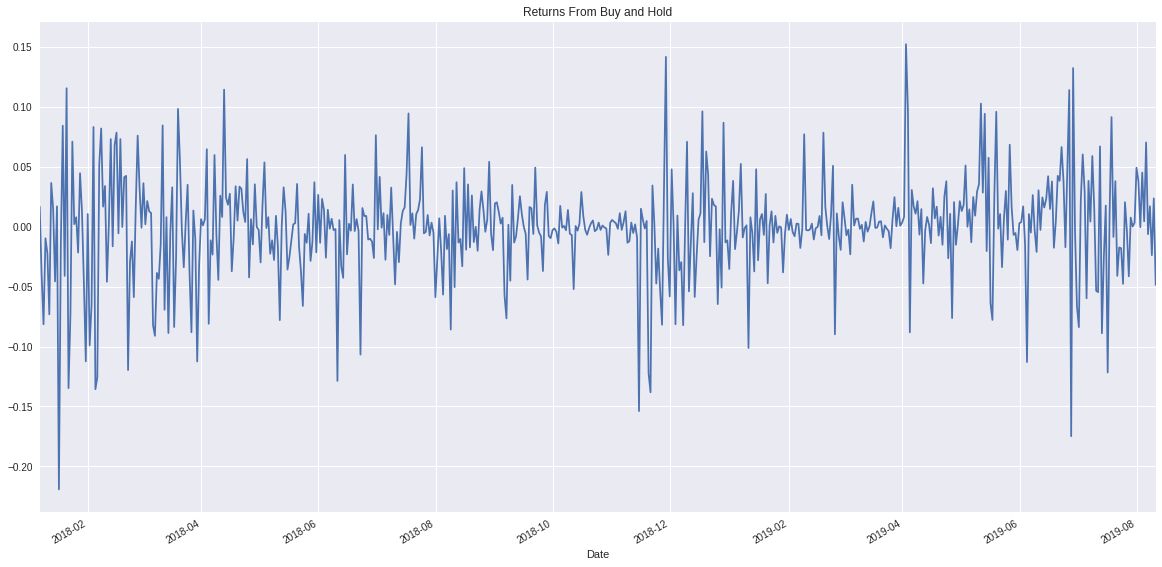

In [18]:
returns["log_returns"].plot(figsize=(20, 10), title="Returns From Buy and Hold")

Plot cumulative return:

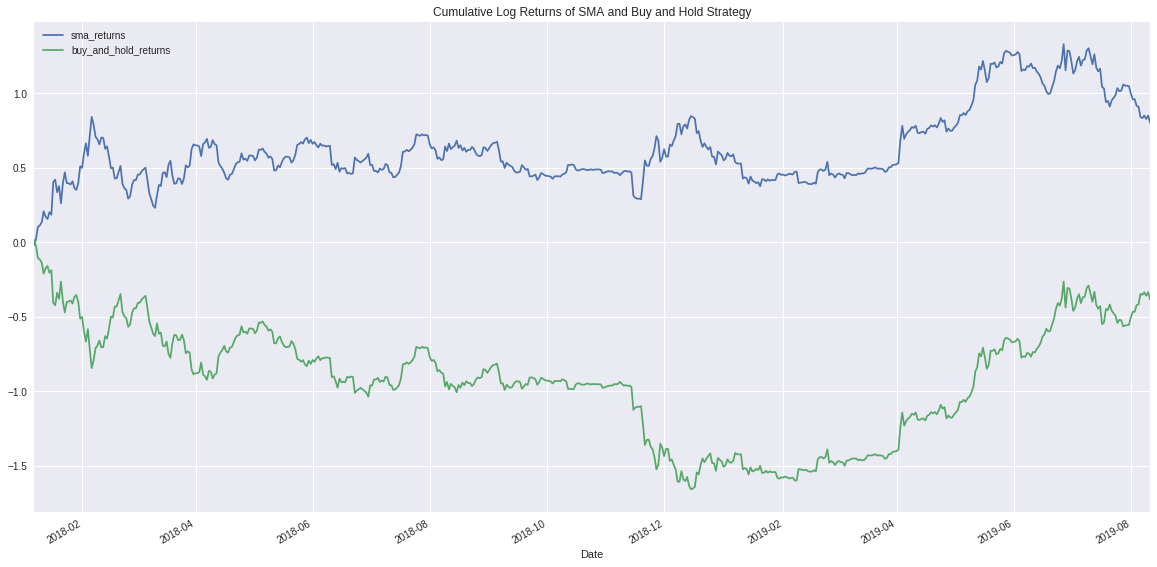

In [19]:
returns["sma_returns"] = returns["strategy_returns"].cumsum()
returns["buy_and_hold_returns"] = returns["log_returns"].cumsum()
returns["perfect_predictor"] = abs(returns["log_returns"]).cumsum()

returns[["sma_returns", "buy_and_hold_returns"]] \
    .plot(figsize=(20, 10), title="Cumulative Log Returns of SMA and Buy and Hold Strategy")

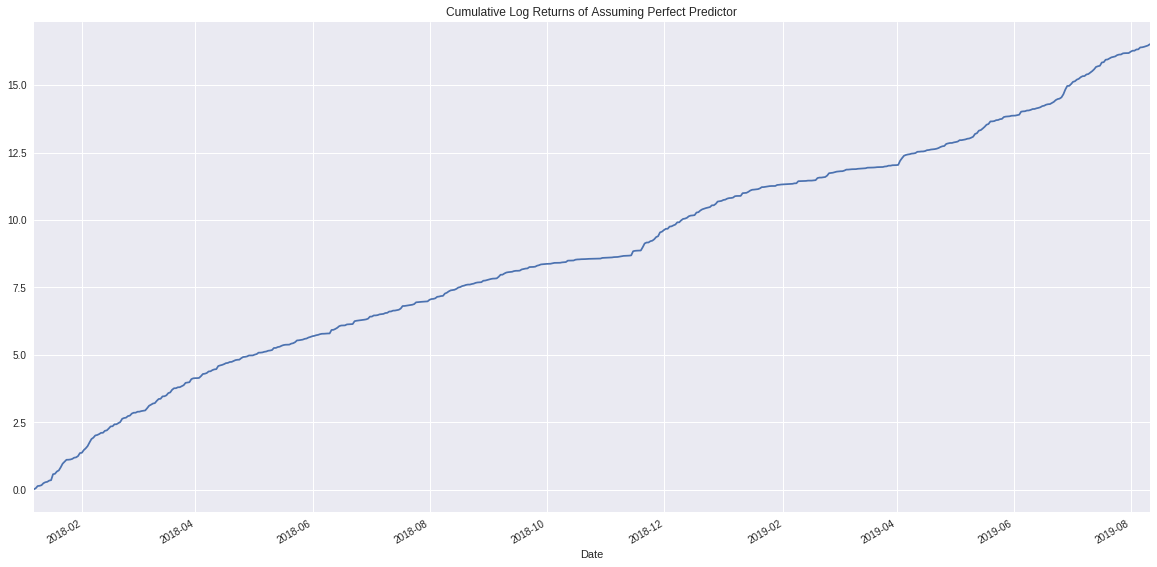

In [20]:
returns["perfect_predictor"].plot(figsize=(20, 10), title="Cumulative Log Returns of Assuming Perfect Predictor")

Detailed analysis on the SMA strategy:

Start date,2018-01-06
End date,2019-08-10
Total months,27
,Backtest
Annual return,41.6%
Cumulative returns,123.3%
Annual volatility,68.2%
Sharpe ratio,0.85
Calmar ratio,0.91
Stability,0.41
Max drawdown,-45.7%


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.68,2018-02-05,2018-03-10,2018-12-14,225
1,40.94,2019-06-26,2019-08-10,NaT,NaN
2,37.52,2018-12-14,2019-01-19,2019-05-03,101
3,25.14,2019-05-27,2019-06-18,2019-06-26,23
4,14.71,2018-01-17,2018-01-20,2018-01-22,4


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


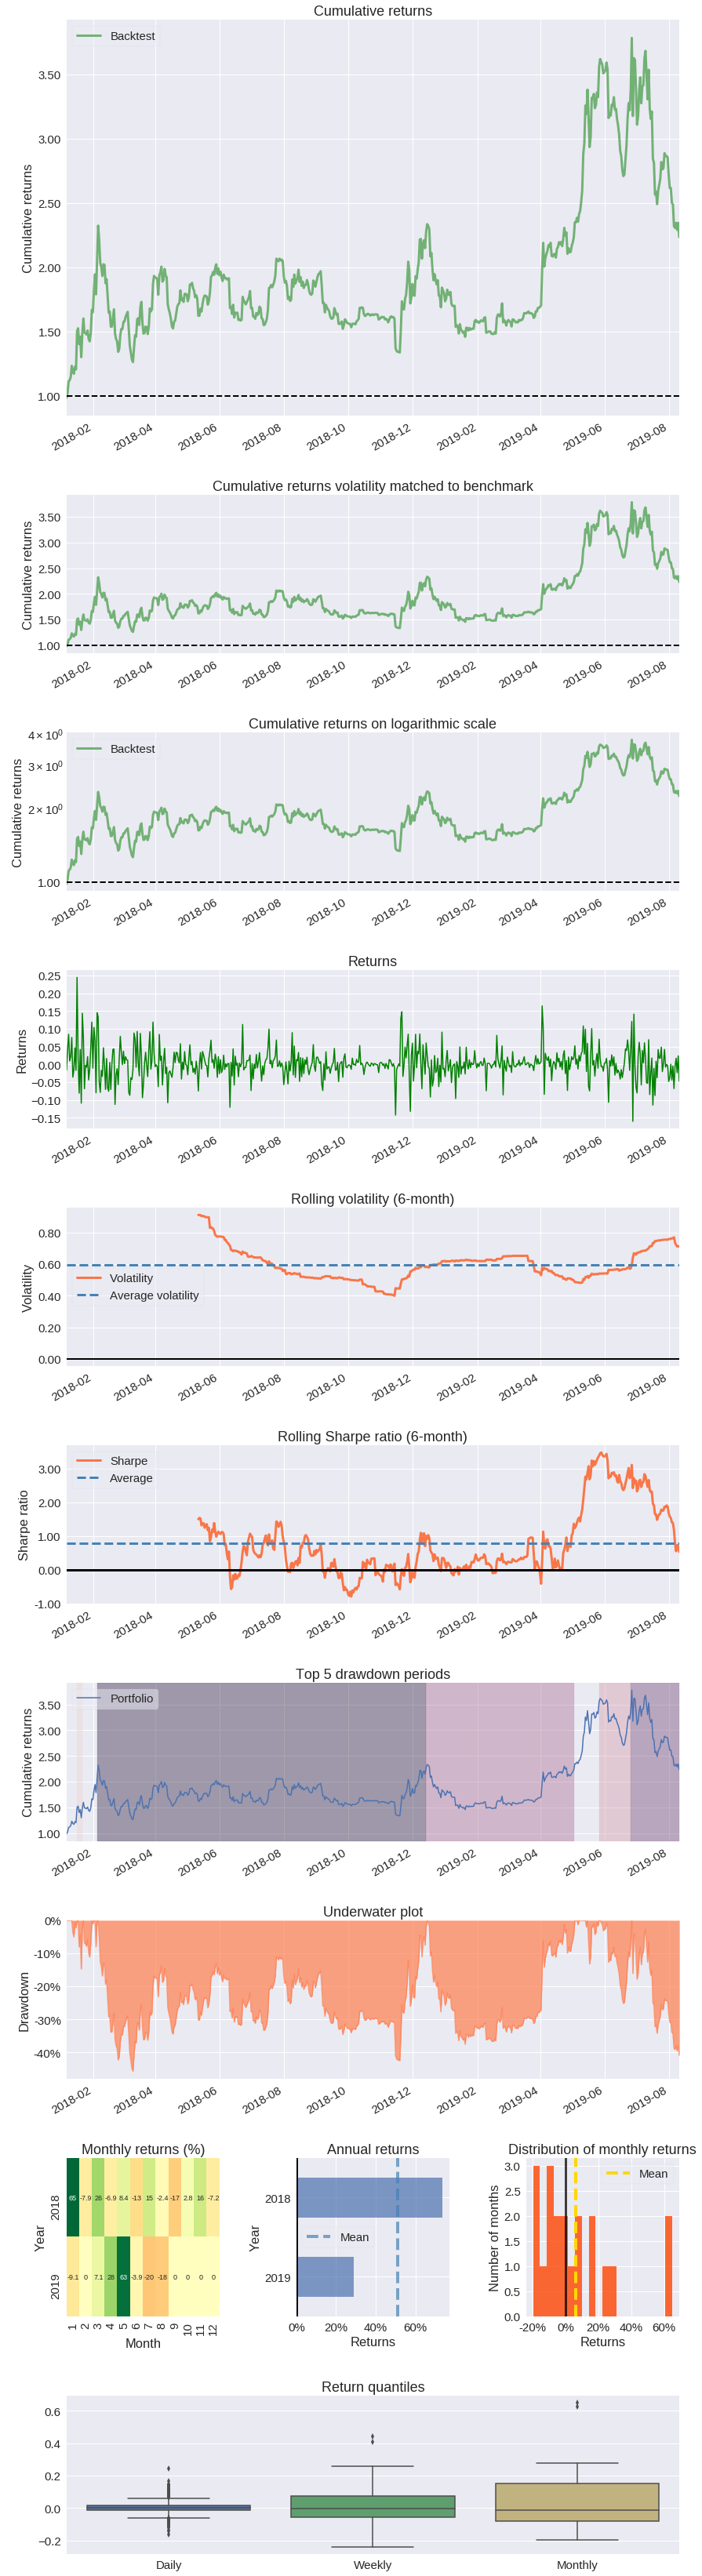

In [21]:
pf.create_returns_tear_sheet(np.exp(returns["strategy_returns"]) - 1)